In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import reverse_geocoder as rg
from datetime import datetime
import datetime

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler # standardlization
from sklearn import preprocessing  # normalization
from sklearn import metrics
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

#all candidate model
models=[LinearRegression(normalize=True),KNeighborsRegressor(),SVR(),Ridge(),Lasso(),MLPRegressor(alpha=20),DecisionTreeRegressor(),ExtraTreeRegressor(),RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),BaggingRegressor(),XGBRegressor()]
models_str=['LinearRegression','KNNRegressor','SVR','Ridge','Lasso','MLPRegressor','DecisionTree','ExtraTree','RandomForest','AdaBoost','GradientBoost','Bagging','xgboost']

In [8]:
def add_element(dataset):
    dataset = dataset.dropna(axis=0,how='any')
    dataset['next15_cnt'] = dataset['next15_cnt'].astype('int')
    date = [i.split(" ")[0] for i in dataset.datatim.astype('str')]
    time = [i.split(" ")[1] for i in dataset.datatim.astype('str')]
    dataset.insert(1,'date',date)
    dataset.insert(2, 'exact_time',time)
    
    
    hour = [int(i.split(" ")[1].split(":")[0]) for i in dataset.datatim.astype('str')]
    minu = [int(i.split(" ")[1].split(":")[1]) for i in dataset.datatim.astype('str')]
    dataset.insert(3,'hour',hour)
    dataset.insert(4,'minute',minu)
    dataset.insert(5, 'hourfloat',dataset.hour+dataset.minute/60)
    dataset.insert(6, 'x', np.sin(2.*np.pi*dataset.hourfloat/24.))
    dataset.insert(7, 'y', np.cos(2.*np.pi*dataset.hourfloat/24.))

    #add day of week categorical attributes
    idlist = [0,1,2,3,4,5,6]
    day = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
    match = pd.DataFrame({'id':idlist, 'day':day})

    dataset.datatim = pd.to_datetime(dataset.datatim)
    day_of_week = [match.loc[i.weekday(),'day'] for i in dataset.datatim]
    dataset.insert(3,'day_of_week',day_of_week)

    #check cyclic attribute
    dataset.sample(50).plot.scatter('x','y').set_aspect('equal') 
    return dataset

## Data Observation

### Location Observation

In [3]:
data_whole = pd.read_csv('hello world.csv')  #load the dataset
data_whole = data_whole.iloc[:,1:]
gridid_whole = np.unique(np.array(data_whole['grid_id']))
gridid_whole  #there are 86 location totally

array([4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4876,
       4877, 4878, 4879, 4880, 4881, 4882, 4883, 4939, 4940, 4941, 4942,
       4943, 4944, 4945, 4946, 4999, 5000, 5001, 5002, 5003, 5004, 5056,
       5057, 5058, 5059, 5060, 5111, 5112, 5113, 5114, 5163, 5164, 5165,
       5166, 5167, 5216, 5217, 5218, 5219, 5220, 5221, 5268, 5269, 5270,
       5271, 5272, 5273, 5274, 5320, 5321, 5322, 5323, 5372, 5373, 5375,
       5376, 5377, 5424, 5425, 5426, 5429, 5430, 5480, 5481, 5530, 5623,
       5624, 5625, 5626, 5627, 5670, 5671, 5672, 5673, 5674], dtype=int64)

In [61]:
data_loc = data_whole[['grid_id','c_long','c_lat']]
data_loc = np.array(data_loc)
data_loc = data_loc.tolist()
data_loc = [list(x) for x in set(tuple(x) for x in data_loc)]

In [62]:
from urllib.parse import quote
from urllib import request
import json

lati = []
long = []
province = []
city = []
district = []
township = []
grid_id = []

for loc in data_loc:
    lat = loc[2]
    lon = loc[1]
    id_ = int(loc[0])
    grid_id.append(id_)
    lati.append(lat)
    long.append(lon)
    
    key = ''  #can import your own API key
    req_url = 'https://restapi.amap.com/v3/geocode/regeo?output=json&location='+str(lon)+','+ str(lat)+'&key='+key+'&radius=900&extensions=all'

    tup = ''
    #print(quote(types))
    with request.urlopen(req_url) as f:
        tup = f.read()
        tup = tup.decode('utf-8')
        
    tup1 = json.loads(tup)
    #print(tup1)
    #print('--------------------------------')
    regeo = tup1['regeocode']
    
    pro = regeo['addressComponent']['province']
    ci = regeo['addressComponent']['city']
    dist = regeo['addressComponent']['district']
    town = regeo['addressComponent']['township']
    
    province.append(pro)
    city.append(ci)
    district.append(dist)
    township.append(town)
    
    #print(loc, lat, lon, pro, ci)
    
loc_info = pd.DataFrame({'grid_id':grid_id, 'Longitude':long, 'Latitude':lati, 'Province':province, 'City':city,
                        'District':district, 'Township':township})

loc_info

,grid_id,Longitude,Latitude,Province,City,District,Township
0,4944,116.407601,24.667101,广东省,梅州市,梅县区,松源镇
1,4811,116.371598,24.650400,广东省,梅州市,梅县区,隆文镇
2,5323,116.398598,24.725700,广东省,梅州市,梅县区,松源镇
3,5060,116.425599,24.683901,广东省,梅州市,梅县区,松源镇
4,4883,116.425599,24.658800,广东省,梅州市,梅县区,松源镇
...,...,...,...,...,...,...,...
81,5429,116.398598,24.742399,广东省,梅州市,梅县区,松源镇
82,5163,116.389603,24.700600,广东省,梅州市,梅县区,松源镇
83,5112,116.407601,24.692200,广东省,梅州市,梅县区,松源镇
84,5624,116.398598,24.775801,广东省,梅州市,梅县区,松源镇


### Time Observation

In [4]:
# calculate cnt after 15 mins
def get_cnt_after_15min(grid_df):
    next15_cnt = []
    grid_df.datatim = pd.to_datetime(grid_df.datatim)
    for i in range(len(grid_df)):
        #print(datetime.timedelta(minutes = 15))
        #print(type(datetime.timedelta(minutes = 15)))
        next_time = grid_df.iloc[i]['datatim'] + datetime.timedelta(minutes = 15)
        cnt_df = grid_df[grid_df['datatim'] == next_time]['cnt']
        if cnt_df.empty:
            cnt = np.nan
        else:
            cnt = cnt_df.iloc[0]
            cnt = int(cnt)
        next15_cnt.append(cnt)
        
    grid_df['next15_cnt'] = next15_cnt
    grid_df = grid_df.dropna(axis=0,how='any')
    return grid_df

In [5]:
def extract_griddf(wholedata, grid_id):
    df_id = data_whole[data_whole['grid_id'] == grid_id]
    df_id_cnt_15min = get_cnt_after_15min(df_id)
    return df_id_cnt_15min

In [6]:
df_id = extract_griddf(data_whole, gridid_whole[0])

In [19]:
df_id

,datatim,date,exact_time,day_of_week,hour,minute,hourfloat,x,y,weekend,holiday,time,grid_id,c_long,c_lat,cnt,next15_cnt
2217,2019-10-01 17:10:00,2019-10-01,17:10:00,Mon,17,10,17.166667,-0.976296,-0.216440,False,True,afternoon,4808,116.344597,24.6504,5488,5364
2245,2019-10-02 21:30:00,2019-10-02,21:30:00,Tue,21,30,21.500000,-0.608761,0.793353,False,True,evening,4808,116.344597,24.6504,5701,5609
2255,2019-10-03 08:40:00,2019-10-03,08:40:00,Wed,8,40,8.666667,0.766044,-0.642788,False,True,morning,4808,116.344597,24.6504,5660,5652
2309,2019-10-05 16:05:00,2019-10-05,16:05:00,Fri,16,5,16.083333,-0.876727,-0.480989,True,True,afternoon,4808,116.344597,24.6504,5727,5812
2337,2019-10-06 20:25:00,2019-10-06,20:25:00,Sat,20,25,20.416667,-0.806445,0.591310,True,True,evening,4808,116.344597,24.6504,6575,6604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251012,2019-12-21 17:30:00,2019-12-21,17:30:00,Fri,17,30,17.500000,-0.991445,-0.130526,True,False,afternoon,4808,116.344597,24.6504,6560,6871
2251083,2019-12-24 11:05:00,2019-12-24,11:05:00,Mon,11,5,11.083333,0.237686,-0.971342,False,False,morning,4808,116.344597,24.6504,6649,6585
2251085,2019-12-24 12:05:00,2019-12-24,12:05:00,Mon,12,5,12.083333,-0.021815,-0.999762,False,False,afternoon,4808,116.344597,24.6504,6799,7032
2251089,2019-12-24 15:00:00,2019-12-24,15:00:00,Mon,15,0,15.000000,-0.707107,-0.707107,False,False,afternoon,4808,116.344597,24.6504,6631,6684


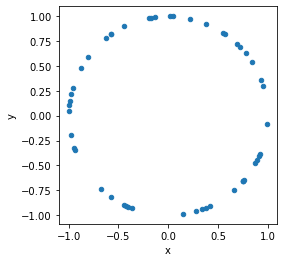

In [13]:
df_id = add_element(df_id)
X_id = df_id[['day_of_week','x','y','weekend','holiday','time','cnt']]
y_id = df_id["next15_cnt"]

In [41]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def draw_ts_adj(timeseries,dataset):
    #plt.ylim(0,25000)
    timeseries.exact_time = pd.to_datetime(timeseries.exact_time)
    timeseries = timeseries.set_index('exact_time')
    timeseries['cnt'].plot()
    
    grid_id = dataset['grid_id'].tolist()[0]
    dayofweek = timeseries['day_of_week'][0]
    return dayofweek, grid_id

def draw_ts_week(dataset, timelist):
    plt.figure(figsize=(20,8))
    dayofweek_ = []
    for i in timelist:
        df_small = dataset[dataset['date']==i]
        day, grid_id = draw_ts_adj(df_small, dataset)
        dayofweek_.append(day)     
    plt.legend(dayofweek_)
    plt.title('Grid ID:' + str(grid_id) + '  ' + timelist[0]+' -- '+timelist[-1])
    plt.show()

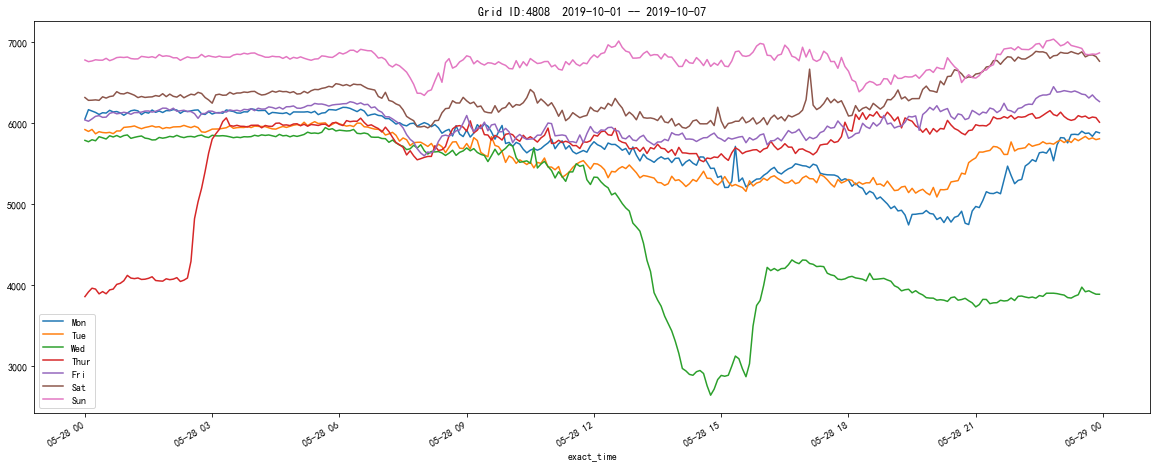

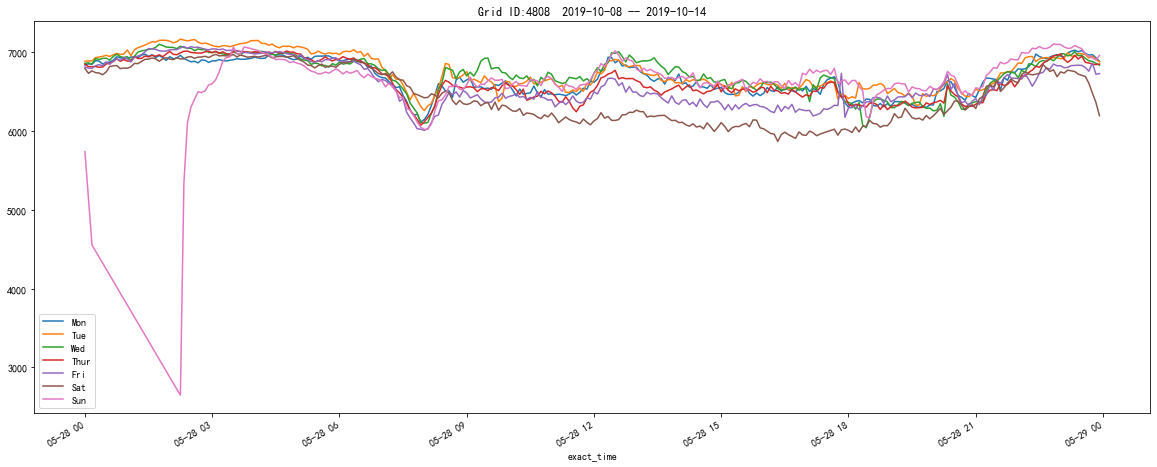

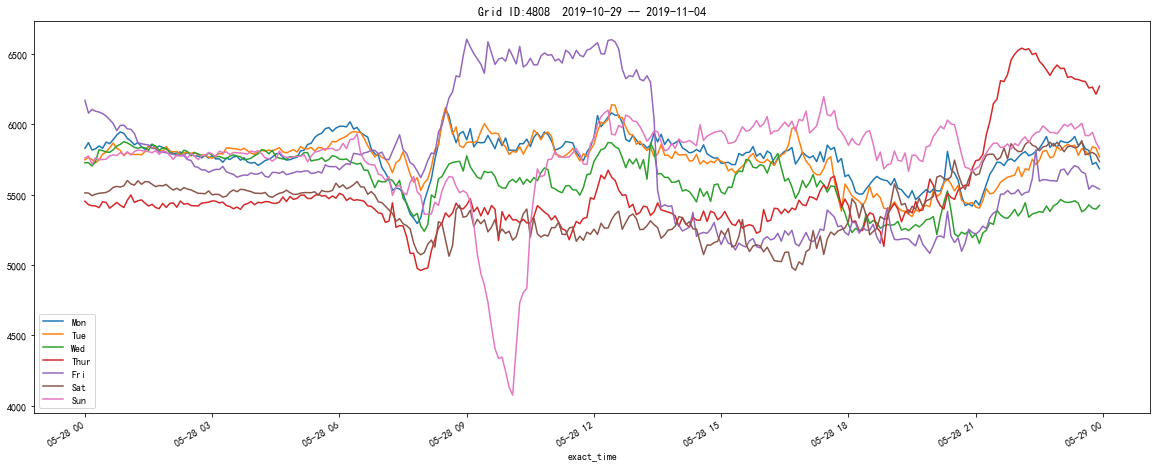

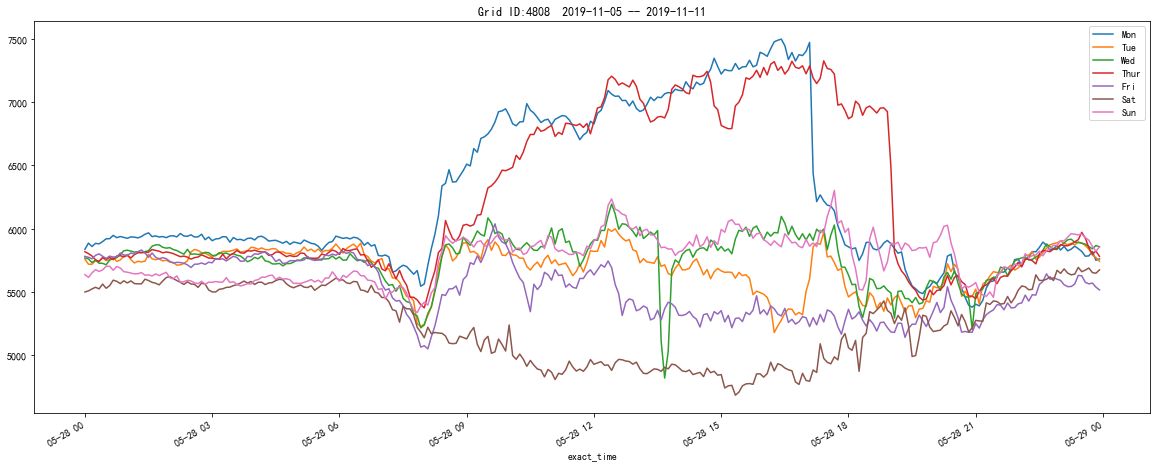

In [42]:
WEEK1 = ["2019-10-01","2019-10-02", "2019-10-03", "2019-10-04", "2019-10-05", "2019-10-06", "2019-10-07"]
WEEK2 = ["2019-10-08","2019-10-09", "2019-10-10", "2019-10-11", "2019-10-12", "2019-10-13", "2019-10-14"]
WEEK3 = ["2019-10-15","2019-10-16", "2019-10-17", "2019-10-18", "2019-10-19", "2019-10-20", "2019-10-21"]
WEEK4 = ["2019-10-22","2019-10-23", "2019-10-24", "2019-10-25", "2019-10-26", "2019-10-27", "2019-10-28"]
WEEK5 = ["2019-10-29","2019-10-30", "2019-10-31", "2019-11-01", "2019-11-02", "2019-11-03", "2019-11-04"]
WEEK6 = ["2019-11-05","2019-11-06", "2019-11-07", "2019-11-08", "2019-11-09", "2019-11-10", "2019-11-11"]
WEEK7 = ["2019-11-12","2019-11-13", "2019-11-14", "2019-11-15", "2019-11-16", "2019-11-17", "2019-11-18"]
WEEK8 = ["2019-11-19","2019-11-20", "2019-11-21", "2019-11-22", "2019-11-23", "2019-11-24", "2019-11-25"]
WEEK9 = ["2019-11-26","2019-11-27", "2019-11-28", "2019-11-29", "2019-11-30", "2019-12-01", "2019-12-02"]


draw_ts_week(df_id, WEEK1)
draw_ts_week(df_id, WEEK2)
draw_ts_week(df_id, WEEK5)
draw_ts_week(df_id, WEEK6)